# demo-04 : directional classification using windowed input

In [11]:
import os
import datetime

from utils.metrics import directional_accuracy_rate
from utils.visualization import plot_predictions

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sqlalchemy import create_engine, sql
from sklearn.preprocessing import StandardScaler

# matplotlib settings
mpl.rcParams["figure.figsize"] = (12, 3)
mpl.rcParams["axes.grid"] = False

# constants
PRINT_RED = '\033[91m'

#------------------------------------------------------------------------------
# Database connection setup
#------------------------------------------------------------------------------

# get postgres environment variables
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB_NAME = os.getenv("PG_DB_NAME")
PG_USERNAME = os.getenv("PG_USERNAME")
PG_PASSWORD = os.getenv("PG_PASSWORD")

# check for missing environment variables
if PG_HOST == None or PG_PORT == None or PG_DB_NAME == None or PG_USERNAME == None or PG_PASSWORD == None:
    print(f'{PRINT_RED}[ ERROR ] Environment variables PG_HOST, PG_PORT, PG_DB_NAME, PG_USERNAME, or PG_PASSWORD not found.')

# hard-code table name
PG_MINUTE_BARS_TABLE = "bars_minute_eastern"
PG_DAY_BARS_TABLE = "bars_day"

# connect to db and open a cursor to perform database operations
conn_string = f"postgresql://{PG_USERNAME}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB_NAME}"
db = create_engine(conn_string)
conn = db.connect()

In [12]:
#------------------------------------------------------------------------------
# Pull data from db and wrangle into correct shape
# (minute bars for NVDA from 09:00-14:00 from 2022/06/01-2022/07/01)
#------------------------------------------------------------------------------

# create empty dataframe to hold bar data
days_data_df = pd.DataFrame(columns=["date", "minute_bars", "timestamp", 'direction'])

# NOTE: db contains minute bars for NVDA,INTC from 2022/06/01 to 2022/07/01 (inclusive)
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 7, 1)

volume_scaler = StandardScaler()

current_date = start_date
day_delta = datetime.timedelta(days=1)

# get previous date's day_bar and minute_bars
previous_day_minute_bars_df = pd.read_sql_query(
    sql=sql.text(f"select * from { PG_MINUTE_BARS_TABLE } where SYMBOL='NVDA' and date(TIMESTAMP)='{ current_date - day_delta }'"),
    con=conn,
)
previous_day_bar_df = pd.read_sql_query(
    sql=sql.text(f"select * from { PG_DAY_BARS_TABLE } where SYMBOL='NVDA' and date(DATE)='{ current_date - day_delta }'"),
    con=conn,
)

# loop over each date and get minute_bars from db
while current_date <= end_date:
    # get current date's day_bar and minute_bars
    day_minute_bars_df = pd.read_sql_query(
        sql=sql.text(f"select * from { PG_MINUTE_BARS_TABLE } where SYMBOL='NVDA' and date(TIMESTAMP)='{ current_date }'"),
        con=conn,
    )
    day_bar_df = pd.read_sql_query(
        sql=sql.text(f"select * from { PG_DAY_BARS_TABLE } where SYMBOL='NVDA' and date(DATE)='{ current_date }'"),
        con=conn,
    )

    # skip day if empty
    if day_minute_bars_df.empty:
        current_date += day_delta
        continue

    # drop symbol column
    day_minute_bars_df.drop("symbol", axis=1, inplace=True)

    # get high and low from previous day
    high = previous_day_bar_df['high'].iloc[0]
    low = previous_day_bar_df['low'].iloc[0]

    # standardize volume using yesterday's data
    volume_scaler.fit(np.reshape(previous_day_minute_bars_df['volume'].values, (-1, 1)))
    standardized_volume = volume_scaler.transform(np.reshape(day_minute_bars_df['volume'].values, (-1, 1)))
    day_minute_bars_df['z_volume'] = standardized_volume

    #--------------------------------------------------------------------------
    # Calculate direction values (1 if next close is higher than current close)
    #--------------------------------------------------------------------------

    directions = np.where(day_minute_bars_df['close'] <= day_minute_bars_df['close'].shift(-1), 1, 0)

    #--------------------------------------------------------------------------
    # Convert timestamps to day/week/year sin and cosine signals
    #--------------------------------------------------------------------------

    # extract timestamps
    timestamps = pd.to_datetime(day_minute_bars_df.pop("timestamp"))

    timestamp_s = timestamps.map(pd.Timestamp.timestamp)

    seconds_per_day = 24 * 60 * 60
    seconds_per_week = seconds_per_day * 7
    seconds_per_year = seconds_per_week * 52.1429

    day_minute_bars_df["day-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_day))
    day_minute_bars_df["day-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_day))

    day_minute_bars_df["week-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_week))
    day_minute_bars_df["week-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_week))

    day_minute_bars_df["year-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_year))
    day_minute_bars_df["year-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_year))

    # insert day minute bars and timestamps to their respecive dataframes
    days_data_df.loc[len(days_data_df), days_data_df.columns] = current_date, day_minute_bars_df, timestamps, directions

    # shift current day bars to previous day
    previous_day_minute_bars_df = day_minute_bars_df
    previous_day_bar_df = day_bar_df

    # go to next day
    current_date += day_delta

#------------------------------------------------------------------------------
# Drop volume columns
#------------------------------------------------------------------------------

for _, day_data_df in days_data_df.iterrows():
    day_data_df["minute_bars"].drop("volume", axis=1, inplace=True)

In [13]:
#------------------------------------------------------------------------------
# Split into training/validation (80%) and test (80%) sets
#------------------------------------------------------------------------------

n = len(days_data_df)  # total number of days

days_train_df = days_data_df[0 : int(n * 0.8)]
days_test_df = days_data_df[int(n * 0.8) :]

In [18]:
#-----------------------------------------------------------------------------
# Create and train a convolutional model
#-----------------------------------------------------------------------------

N_FEATURES = len(days_data_df.iloc[0]['minute_bars'].columns)
INPUT_WINDOW_LEN = 10
BATCH_SIZE = 32 # not much clue what this does
CONV_WIDTH = 3 # no clue what this does
EPOCHS = 100 # no clue what this does
FILTERS = 32 # no clue what this does
LEARNING_RATE = 0.001 # not much clue what this does

conv_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(INPUT_WINDOW_LEN, N_FEATURES)), # Flatten the input shape to a vector
    tf.keras.layers.Dense(64, activation='relu'), # First hidden layer with 64 units and ReLU activation
    tf.keras.layers.Dropout(0.2), # Add dropout regularization to prevent overfitting
    tf.keras.layers.Dense(64, activation='relu'), # Second hidden layer with 64 units and ReLU activation
    tf.keras.layers.Dropout(0.2), # Add dropout regularization
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with one unit and sigmoid activation
])

conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# loop over training days to fit the model
for index, day_data in days_train_df.iterrows():
    print(days_data_df.iloc[index]['date'])

    # Extract the minute bars for this day
    minute_bars = day_data["minute_bars"].values

    # Extract the target variable (which we want to predict) from the minute bars
    targets = day_data['direction'][INPUT_WINDOW_LEN-1:-1]

    minute_bars_indexes = [[i + j for j in range(INPUT_WINDOW_LEN)] for i in range(len(minute_bars) - INPUT_WINDOW_LEN)]

    minute_bars_windows = minute_bars[minute_bars_indexes]

    # Fit the model to the training data
    conv_model.fit(
        x=minute_bars_windows,
        y=targets,
        epochs=EPOCHS,
        verbose=0,
        batch_size=BATCH_SIZE,
    )

2022-06-01
Epoch 1/100
 1/13 [=>............................] - ETA: 4s - loss: 53.6237 - binary_accuracy: 0.4375

2023-05-02 20:22:17.747452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 27ms/step - loss: 28.3316 - binary_accuracy: 0.4745
Epoch 2/100
13/13 [==============================] - 0s 11ms/step - loss: 12.6892 - binary_accuracy: 0.5085
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 8.0519 - binary_accuracy: 0.4866
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 5.5637 - binary_accuracy: 0.5036
Epoch 5/100
13/13 [==============================] - 0s 9ms/step - loss: 4.0809 - binary_accuracy: 0.4891
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 2.5272 - binary_accuracy: 0.4769
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 1.9845 - binary_accuracy: 0.4574
Epoch 8/100
13/13 [==============================] - 0s 9ms/step - loss: 1.5456 - binary_accuracy: 0.5036
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 1.3237 - binary_accuracy: 0.5085
Epoch 10/100
13/13 [==============================] 

2022-06-27


2023-05-02 20:27:49.418532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.7036213874816895, Test MAE: 0.4878048896789551


2023-05-02 20:27:49.658561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


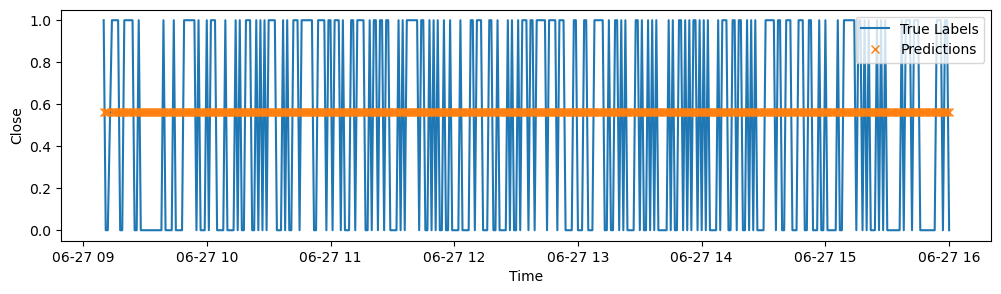

2022-06-28
Test loss: 0.7101519107818604, Test MAE: 0.4611528813838959


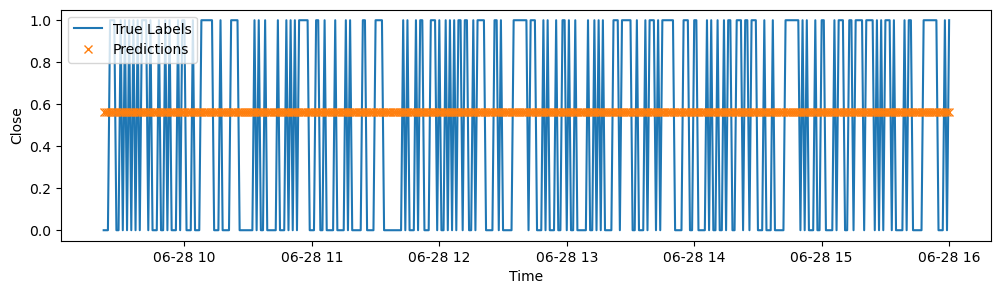

2022-06-29
Test loss: 0.6973544359207153, Test MAE: 0.5133820176124573


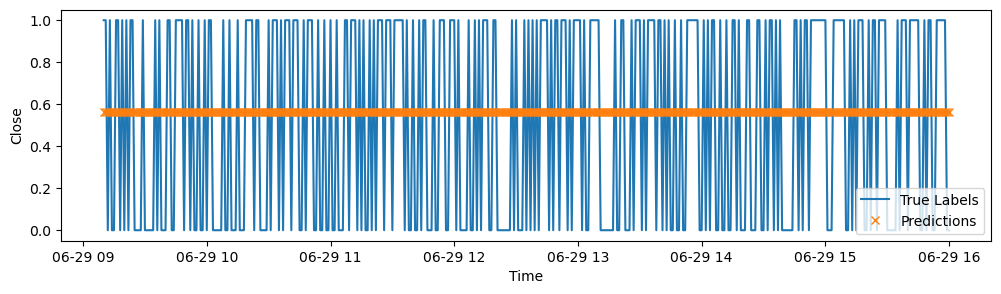

2022-06-30
Test loss: 0.6991428732872009, Test MAE: 0.5060827136039734


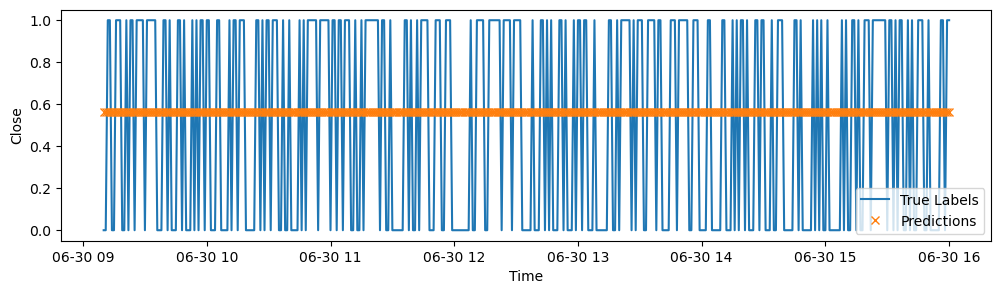

2022-07-01
Test loss: 0.704508364200592, Test MAE: 0.4841849207878113


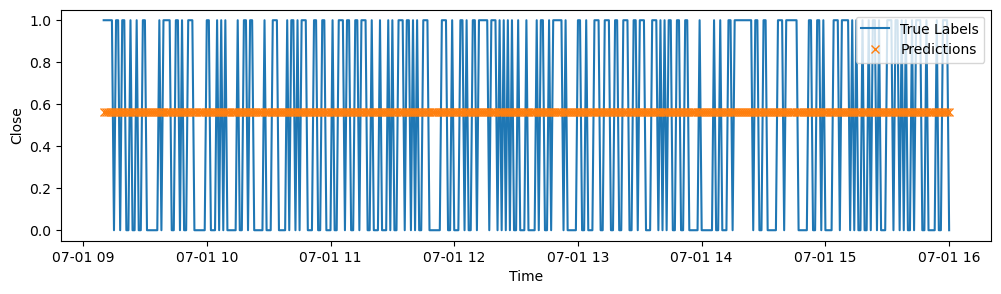

ZeroDivisionError: division by zero

In [20]:
for index, day_data in days_test_df.iterrows():
    print(days_data_df.iloc[index]['date'])

    # Extract the minute bars for this day
    minute_bars = day_data["minute_bars"].values

    # Extract the target variable (which we want to predict) from the minute bars
    inputs = day_data["minute_bars"]['close'].values[INPUT_WINDOW_LEN-1:-1]
    targets = day_data['direction'][INPUT_WINDOW_LEN-1:-1]

    minute_bars_indexes = [[i + j for j in range(INPUT_WINDOW_LEN)] for i in range(len(minute_bars) - INPUT_WINDOW_LEN)]

    minute_bars_windows = minute_bars[minute_bars_indexes]
    
    # Evaluate the model on the test data
    loss, mae = conv_model.evaluate(x=minute_bars_windows, y=targets, verbose=0)
    print(f"Test loss: {loss}, Test MAE: {mae}")
    
    predictions = conv_model.predict(x=minute_bars_windows, verbose=0, steps=None).flatten()

    plot_predictions(labels=targets, predictions=predictions, timestamps=day_data['timestamp'].values[INPUT_WINDOW_LEN:])